In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm

C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

C:\Users\USER\AppData\Roaming\Python\Python36\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [3]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [4]:
##GPU 사용 시
device = torch.device("cuda:0")

In [5]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

# Load Dataset

In [6]:
import gluonnlp as nlp

In [7]:
kobert_get_tokenizer = get_tokenizer()
kobert_model, kobert_vocab = get_pytorch_kobert_model()
kobert_tokenizer = nlp.data.BERTSPTokenizer(kobert_get_tokenizer, kobert_vocab, lower=False)

using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_v1.zip
using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


In [8]:
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_dataset = nlp.data.TSVDataset(data_path+"koco_hate_train.txt", num_discard_samples=1)
koco_test_dataset = nlp.data.TSVDataset(data_path+"koco_hate_test.txt", num_discard_samples=1)

In [9]:
def detokenizer(tokens):
    decode_tokens = list()
    for idx in tokens:
        token = kobert_vocab.idx_to_token[idx]
        if token == '[PAD]':
            break
        decode_tokens.append(token)
    return decode_tokens

In [10]:
transform = nlp.data.BERTSentenceTransform(
            kobert_tokenizer, max_seq_length=max_len, pad=True, pair=False)
token_list = [transform([i[0]]) for i in koco_test_dataset]

In [11]:
idx = 70
detoken_list = detokenizer(token_list[idx][0])
print(koco_test_dataset[idx][0])
print(detoken_list)

짠돌이보단 낫다
['[CLS]', '▁', '짠', '돌', '이', '보', '단', '▁', '낫', '다', '[SEP]']


In [12]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [13]:
koco_train_BERTDataset = BERTDataset(koco_train_dataset, 0, 1, kobert_tokenizer, max_len, True, False)
koco_test_BERTDataset = BERTDataset(koco_test_dataset, 0, 1, kobert_tokenizer, max_len, True, False)

In [14]:
koco_train_BERTDataset.__getitem__(1)

(array([   2,  517,   54,  517,   54,  517,   54,  517,   54, 4958, 7206,
        2149, 7119, 7095, 1678, 2468,  517,   54,  517,   54,  517,   54,
        1458, 5655,  517, 5450, 5439, 6797, 6117, 5785, 6213, 6699,  517,
          54,  517,   54,  517,   54, 1185, 6213, 6699, 5916, 7095, 2948,
        7766, 7088, 2149, 7416, 3166, 7318, 6224, 7864, 5703,    0,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1]),
 array(55),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0)

In [15]:
koco_train_dataloader = torch.utils.data.DataLoader(koco_train_BERTDataset, batch_size=batch_size, num_workers=0)
koco_test_dataloader = torch.utils.data.DataLoader(koco_test_BERTDataset, batch_size=batch_size, num_workers=0)

# Model

In [16]:
from coral_pytorch.losses import CoralLoss
from coral_pytorch.layers import CoralLayer
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.losses import coral_loss

In [43]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.hidden_size = hidden_size
        self.coral_layer = CoralLayer(self.hidden_size, num_classes)
                 
        #self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
            
        self.logits = self.coral_layer(out)
        self.probas = torch.sigmoid(self.logits)
        return self.logits, self.probas

In [44]:
model = BERTClassifier(kobert_model,  dr_rate=0.5).to(device)

In [45]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [46]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
#loss_fn = nn.CrossEntropyLoss()

In [47]:
t_total = len(koco_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [48]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [49]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [50]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label,logits, probas):

    mae, mse, acc, num_examples = 0., 0., 0., 0
    device=torch.device("cpu")

    targets = label.float().to(device)
    predicted_labels = proba_to_label(probas).float().cpu()

    num_examples += targets.size(0)
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

# Train Model

In [51]:
coral = CoralLoss()

In [52]:
iw = torch.tensor([1,1]).to(device)

In [53]:
num_epochs = 10
for e in range(num_epochs):
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        logits, probas = model(token_ids, valid_length, segment_ids)
        levels = levels_from_labelbatch(label.view(-1) , num_classes=3).to(device)
        loss = coral(logits, levels, importance_weights=iw)
        #loss = loss_fn(out, label) #cross_entropy loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        #mae_and_mse += compute_mae_and_mse(label,logits, probas)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} ".format(e+1, batch_id+1, loss.data.cpu().numpy()))
        
        del loss, label, token_ids, valid_length, segment_ids
        torch.cuda.empty_cache()
       
    print("epoch {}".format(e+1))

  0%|          | 0/124 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.57198166847229 
epoch 1


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6304812431335449 
epoch 2


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.521632194519043 
epoch 3


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.8633986711502075 
epoch 4


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5981287956237793 
epoch 5


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.5578042268753052 
epoch 6


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.44737890362739563 
epoch 7


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.37373870611190796 
epoch 8


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.36036914587020874 
epoch 9


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.3584144115447998 
epoch 10


In [54]:
torch.save(model.state_dict(), 'koco_kobert_coral_model.pt')

# Test Model

In [55]:
preds_list=[] #predict 값 list 생성
proba_list=[]
test_acc=0
#model_path = 'C:/Users/USER/Desktop/2022/koco_kobert_model.pt'
#model_path = 'koco_kobert_coral_model.pt'
#model.load_state_dict(torch.load('koco_kobert_coral_model.pt'))
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_test_dataloader)):
    with torch.no_grad():
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        logits, probas = model(token_ids, valid_length, segment_ids)
        proba_list.extend(probas.tolist())
        predict_labels = proba_to_label(probas)
        preds_list.extend(predict_labels.tolist())
        
        del label, token_ids, valid_length, segment_ids, logits, probas
        torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

# Confusion Matrix

In [56]:
y_test = koco_test_BERTDataset.labels
preds_list = preds_list

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       160
           1       0.54      0.44      0.48       189
           2       0.74      0.56      0.64       122

    accuracy                           0.60       471
   macro avg       0.62      0.61      0.60       471
weighted avg       0.61      0.60      0.59       471



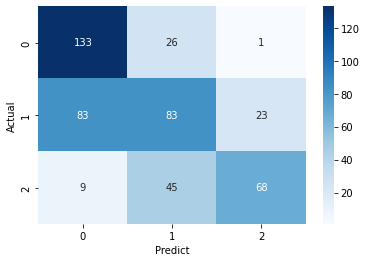

In [57]:
## classification_report
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [58]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [59]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.4183)
tensor(0.4607)


# Threshold 설정

In [ ]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [147]:
predicts_threshold = custom_proba_to_label(proba_list, 0.1, 0.9)

In [148]:
y_test = koco_test_BERTDataset.labels
preds_list = predicts_threshold

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       160
           1       0.58      0.58      0.58       189
           2       0.78      0.53      0.63       122

    accuracy                           0.64       471
   macro avg       0.67      0.63      0.64       471
weighted avg       0.65      0.64      0.64       471



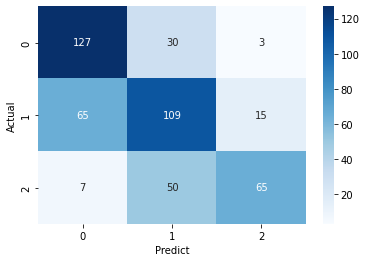

In [149]:
## classification_report
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [150]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3822)
tensor(0.4246)


In [86]:
proba_list

[[0.0032375261653214693, 0.0019661637488752604],
 [0.8873692154884338, 0.8269474506378174],
 [0.7873043417930603, 0.6918436288833618],
 [0.011815118603408337, 0.00719970278441906],
 [0.19128894805908203, 0.1254659742116928],
 [0.9983559250831604, 0.9972922205924988],
 [0.003235358977690339, 0.001964845461770892],
 [0.003165199887007475, 0.0019221846014261246],
 [0.003321649506688118, 0.0020173187367618084],
 [0.0031643828842788935, 0.0019216879736632109],
 [0.0031304359436035156, 0.0019010467221960425],
 [0.7388147711753845, 0.6317698955535889],
 [0.003337544621899724, 0.0020269849337637424],
 [0.9918109178543091, 0.9865698218345642],
 [0.9982138872146606, 0.9970585107803345],
 [0.6710608601570129, 0.5530463457107544],
 [0.7433798909187317, 0.6372874975204468],
 [0.9983267188072205, 0.9972442388534546],
 [0.7340567708015442, 0.6260489225387573],
 [0.1535690724849701, 0.09913452714681625],
 [0.7305470705032349, 0.6218481063842773],
 [0.8849231600761414, 0.8234502673149109],
 [0.59896939

# Kaggle Data

In [60]:
import pandas as pd
kaggle_hate_dataset = nlp.data.TSVDataset(data_path+"kaggle_hate_test.txt", num_discard_samples=1)
kaggle_hate_df = pd.read_csv(data_path+"kaggle_hate_test.txt", sep='\t')
kaggle_test_BERTDataset = BERTDataset(kaggle_hate_dataset, 0, 1, kobert_tokenizer, max_len, True, False)
kaggle_test_dataloader = torch.utils.data.DataLoader(kaggle_test_BERTDataset, batch_size=batch_size, num_workers=0)

In [61]:
preds_list=[] #predict 값 list 생성
proba_list=[]
test_acc=0
#model_path = 'C:/Users/USER/Desktop/2022/koco_kobert_model.pt'
#model_path = 'koco_kobert_coral_model.pt'
#model.load_state_dict(torch.load('koco_kobert_coral_model.pt'))
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(kaggle_test_dataloader)):
    with torch.no_grad():
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        logits, probas = model(token_ids, valid_length, segment_ids)
        proba_list.extend(probas.tolist())
        predict_labels = proba_to_label(probas)
        preds_list.extend(predict_labels.tolist())
        
        del label, token_ids, valid_length, segment_ids, logits, probas
        torch.cuda.empty_cache()

  0%|          | 0/16 [00:00<?, ?it/s]

In [62]:
preds_list = preds_list

In [63]:
pred_df = pd.DataFrame(preds_list)
kaggle_df = pd.concat([kaggle_hate_df['comments'], pred_df[0]], axis=1)
kaggle_df.columns = ['comments', 'label']
kaggle_df

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,1
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,2
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,2


In [64]:
kaggle_df.to_csv("kaggle_hate_KoBERT_CORAL.csv", index=False, encoding='utf-8')